### Importing GT

In [1]:
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
from compas.geometry import oriented_bounding_box_numpy
from pytorch3d.ops import box3d_overlap
import torch
import os
import open3d as o3d
import matplotlib.pyplot as plt
import sys
import torch
from torch import nn
from copy import deepcopy

sys.path.append('box_estimation/Pointnet_Pointnet2_pytorch')
sys.path.append('box_estimation/Pointnet_Pointnet2_pytorch/models')

In [2]:
labels_foler = "../labelCloud/labels_9DoF"
filenames = os.listdir(labels_foler)
filenames = [f for f in filenames if "_classes" not in f and f.endswith(".json")]
for file in filenames:
    j = json.load(open(labels_foler + "/" + file))
    for object in j["objects"]:
        object['rotations']['x'] = 0
        object['rotations']['y'] = 0

    json.dump(j, open(labels_foler + "/" + file, "w"))

In [3]:
def sincos_to_angle(sin_val, cos_val):
    angle = torch.atan2(sin_val, cos_val)  # Get the angle in radians
    angle = angle % (2 * np.pi)  # Ensure the angle is in the range [0, 2*pi)
    angle = angle / (2 * np.pi)  # Scale to [0, 1]
    return angle.numpy()

def angles_to_sincos(angles):
    sin_angles = torch.sin(angles * 2 * np.pi)  # Assuming angles are scaled between 0 and 1
    cos_angles = torch.cos(angles * 2 * np.pi)
    return np.array([sin_angles.numpy(), cos_angles.numpy()])

def normalize_point_cloud(point_cloud):
    """
    Normalize the point cloud and the relative oriented bounding box (OBB).
    
    Parameters:
    point_cloud (np.ndarray): The point cloud as an array of shape (N, 3).
    obb_vertices (np.ndarray): OBB is centroid, dimensions, and rotations. (3, 3, 3)
    
    Returns:
    np.ndarray: The normalized point cloud.
    np.ndarray: The normalized OBB, rotations are scaled between 0 and 1
    """
    # Calculate the centroid of the point cloud
    centroid = np.mean(point_cloud, axis=0)
    
    centered_pc = point_cloud - centroid

    # Calculate the maximum distance from the origin for the point cloud points
    max_distance = np.max(np.linalg.norm(centered_pc, axis=1))
    
    # Scale point cloud points
    scaled_pc = centered_pc / max_distance

    
    return scaled_pc, max_distance, centroid

def denormalize_obb(normalized_obb, max_distance, original_centroid):
    """
    Denormalize the point cloud and the relative oriented bounding box (OBB).
    
    Parameters:
    normalized_pc (np.ndarray): The normalized point cloud as an array of shape (N, 3).
    normalized_obb (np.ndarray): The normalized OBB, rotations are scaled between 0 and 1.
    max_distance (float): The maximum distance used for normalization.
    original_centroid (np.ndarray): The original centroid of the point cloud.
    
    Returns:
    np.ndarray: The denormalized point cloud.
    np.ndarray: The denormalized OBB.
    """
    # Extract normalized OBB components
    normalized_obb_centroid = deepcopy(normalized_obb[:3])
    normalized_obb_dimensions = deepcopy(normalized_obb[3:6])
    
    sin_cos_rx = torch.tensor(deepcopy(normalized_obb[6:8]))
    sin_cos_ry = torch.tensor(deepcopy(normalized_obb[8:10]))
    sin_cos_rz = torch.tensor(deepcopy(normalized_obb[10:12]))
    
    # Convert sin and cos back to angles
    denorm_rx = sincos_to_angle(sin_cos_rx[0], sin_cos_rx[1])
    denorm_ry = sincos_to_angle(sin_cos_ry[0], sin_cos_ry[1])
    denorm_rz = sincos_to_angle(sin_cos_rz[0], sin_cos_rz[1])
    
    denorm_rotations = np.array([denorm_rx, denorm_ry, denorm_rz]) * 360
    
    # Denormalize the point cloud and OBB components
    denorm_obb_centroid = normalized_obb_centroid * max_distance + original_centroid
    denorm_obb_dimensions = normalized_obb_dimensions * max_distance
    
    denorm_obb = np.concatenate([denorm_obb_centroid, denorm_obb_dimensions, denorm_rotations])
    
    return denorm_obb

In [4]:
from box_estimation.Pointnet_Pointnet2_pytorch.models.pointnet_utils import PointNetEncoder
class PointCloudNet(nn.Module):
    def __init__(self):
        super(PointCloudNet, self).__init__()
        self.backbone = PointNetEncoder(global_feat=True, feature_transform=False, channel = 3)
        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = x[0]
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        x = x.view(-1, 1, 8)
        return x

    def train_model(self, num_epochs, optimizer, criterion, train_loader, test_loader, device):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(tqdm(train_loader)):
                points, box, _, _ = data                
                points, box = points.to(device), box.to(device)
                optimizer.zero_grad()
                outputs = model(points)
                loss = criterion(outputs, box)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            print(f"Epoch {epoch} - Loss: {running_loss / len(train_loader)}")

            model.eval()
            running_loss = 0.0
            for i, data in enumerate(tqdm(test_loader)):
                points, box, _, _ = data
                points, box = points.to(device), box.to(device)
                outputs = model(points)
                loss = criterion(outputs, box)
                running_loss += loss.item()
            
            if running_loss < best_val_loss:
                best_val_loss = running_loss
                torch.save(model.state_dict(), "pc_net.pth")
            print(f"Validation Loss: {running_loss / len(test_loader)}")

device = torch.device("mps")
model = PointCloudNet()
model.to(device)
model.train()
x = torch.randn(10, 3, 120, device = device)
model(x).shape


torch.Size([10, 1, 8])

In [5]:
IOU_THRESHOLD = .0
LABEL_FOLDER = "labels_9DoF/"

gt_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "gt" in f]
pred_jsons = [f for f in os.listdir(LABEL_FOLDER) if f.endswith('.json') and "pred" in f]
gt_jsons.sort(), pred_jsons.sort()
gt_jsons = [file for file in gt_jsons if "515" not in file]
pred_jsons = [file for file in pred_jsons if "515" not in file]
gt_jsons, pred_jsons

(['1_cropped_gt.json',
  '2_cropped_gt.json',
  '3_gt.json',
  '5_gt.json',
  '6_gt.json',
  '7_gt.json'],
 ['1_cropped_pred.json',
  '2_cropped_pred.json',
  '3_pred.json',
  '5_pred.json',
  '6_pred.json',
  '7_pred.json'])

In [6]:
def compute_3d_IoU(box1, box2):
    box1 = torch.tensor(box1, dtype=torch.float32).unsqueeze(0)
    box2 = torch.tensor(box2, dtype=torch.float32).unsqueeze(0)
    vol, IoU =  box3d_overlap(box1, box2)

    return IoU.item()

In [7]:
points_unit = [
        [0.9, 0.9, 0.9],
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1],
    ]
box = oriented_bounding_box_numpy(np.array(points_unit))
box

[[0.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0]]

In [8]:
def reorder_vertices(box):
    """
    A unit cube, defined with the pythorch3d convention, has the following vertices:
        [0, 0, 0],                    (4) +---------+. (5)
        [1, 0, 0],                        | ` .     |  ` .
        [1, 1, 0],                        | (0) +---+-----+ (1)
        [0, 1, 0],                        |     |   |     |
        [0, 0, 1],                    (7) +-----+---+. (6)|
        [1, 0, 1],                        ` .   |     ` . |
        [1, 1, 1],                        (3) ` +---------+ (2)
        [0, 1, 1],
    
    While the OrientedBoundingBox from Open3D has the following vertices:
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]

    This function reorders the vertices of the OrientedBoundingBox to match the pytorch3d convention.
    This allows to use the official IoU function from Pytorch3D.
    """
    assert box.shape == (8, 3)

    reordered = [
        box[0], box[1], box[7], box[2],
        box[3], box[6], box[4], box[5]
    ]
    return np.array(reordered)

In [9]:
def create_obb_from_description(centroid, dimensions, rotations):
    # Extract centroid, dimensions, and rotations
    cx, cy, cz = centroid["x"], centroid["y"], centroid["z"]
    length, width, height = dimensions["length"], dimensions["width"], dimensions["height"]
    rx, ry, rz = rotations["x"], rotations["y"], rotations["z"]

    # Create the 8 corners of the box before rotation and translation
    dx = length / 2
    dy = width / 2
    dz = height / 2

    corners = np.array([
        [-dx, -dy, -dz],
        [ dx, -dy, -dz],
        [ dx,  dy, -dz],
        [-dx,  dy, -dz],
        [-dx, -dy,  dz],
        [ dx, -dy,  dz],
        [ dx,  dy,  dz],
        [-dx,  dy,  dz]
    ])

    # Apply rotations
    rotation = R.from_euler('xyz', [rx, ry, rz], degrees=True)
    rotated_corners = rotation.apply(corners)

    # Apply translation (centroid)
    translated_corners = rotated_corners + np.array([cx, cy, cz])

    return translated_corners

In [10]:
def get_box(model, points,  device):
    device = torch.device(device)
    model = model.to(device)
    points, max_distance, centroid = normalize_point_cloud(points)
    points = torch.tensor(points, dtype = torch.float32)
    if points.shape[0] > 1024:
        points = points[torch.randperm(points.shape[0])[:1024]]
    if points.shape[0] < 1024:
        points = torch.cat([points, torch.zeros(1024 - len(points), 3)])
    assert points.shape[0] == 1024
        
    points = points.permute(1, 0)
    points = points.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        box = model(points.to(device)).detach().cpu().squeeze(0)
        fake_rot = torch.tensor([[0.0, 1.0]])
        box = torch.cat([box[:, :6], fake_rot, fake_rot, box[:, 6:]], dim = 1).squeeze(0).numpy()
        box = denormalize_obb(box, max_distance, centroid)
        box_centroid = box[:3]
        box_dimensions = box[3:6]
        box_rotations = box[6:]
        box = create_obb_from_description(
            {"x": box_centroid[0], "y": box_centroid[1], "z": box_centroid[2]},
            {"length": box_dimensions[0], "width": box_dimensions[1], "height": box_dimensions[2]},
            {"x": box_rotations[0], "y": box_rotations[1], "z": box_rotations[2]}
        )
        return box

In [11]:
def get_z_aligned_box(pcd):
        temp = deepcopy(pcd)

        points = np.asarray(temp.points)

        mean = np.mean(np.asarray(points), axis=0)

        # Compute PCA on the XY components only
        xy_points = np.asarray(points)[:, :2] - mean[:2]
        cov_matrix = np.dot(xy_points.T, xy_points) / len(xy_points)
        eigvals, eigvecs = np.linalg.eig(cov_matrix)

        # Align primary component with the X-axis
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        R = temp.get_rotation_matrix_from_xyz((0, 0, -angle))
        temp.rotate(R, center=mean)

        # Compute the axis-aligned bounding box of the rotated point cloud
        aabb = temp.get_axis_aligned_bounding_box()
        # convert aabb to oriented bbox
        aabb = o3d.geometry.OrientedBoundingBox.create_from_axis_aligned_bounding_box(
            aabb
        )

        # Apply inverse rotation to the bounding box
        aabb.rotate(R.T, center=mean)

        return np.asarray(aabb.get_box_points())

In [12]:
class Obj:
    def __init__(self, label, bbox):
        assert isinstance(label, str)
        assert isinstance(bbox, o3d.geometry.OrientedBoundingBox)
        self.label = label
        self.bbox = reorder_vertices(np.asarray(bbox.get_box_points()))
        self.points = None
    def clean_points(self, points):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.estimate_normals()
        clean, _ = pcd.remove_statistical_outlier(nb_neighbors=100, std_ratio=1.0)
        return np.asarray(clean.points)

class Gt_Obj(Obj):
    def __init__(self, label, bbox, box_feat, map_pcd):
        super().__init__(label, bbox)
        cropped_pcd = map_pcd.crop(self.OBB())
        #cropped_pcd = self.clean_points(np.asarray(cropped_pcd.points))
        #cropped_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cropped_pcd))
        self.points = np.asarray(cropped_pcd.points)
        self.centroid = np.mean(bbox.get_box_points(), axis=0)
        self.box_feat = box_feat
        #map_pcd = map_pcd.crop(self.OBB())
        self.bbox = reorder_vertices(np.asarray(self.OBB().get_box_points()))
    def OBB(self):
        if self.points is not None:
            try:
                self.bbox = oriented_bounding_box_numpy(np.asarray(self.points))
            except:
                pass
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [0, 1, 0]
        return box

class Pred_Obj(Obj):
    def __init__(self, id, label, bbox, points, score):
        super().__init__(label, bbox)
        self.points = self.clean_points(points)
        self.centroid = np.mean(points, axis=0)
        self.id = id
        self.score = score
        self.bbox = oriented_bounding_box_numpy(self.points)
        #self.bbox = get_box(model, self.points, "mps")
        #self.bbox = get_z_aligned_box(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(self.points)))
        self.bbox = reorder_vertices(np.asarray(self.OBB().get_box_points()))

    def OBB(self):
        box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(self.bbox))
        box.color = [1, 0, 0]
        return box

class ObjList:
    def __init__(self, objects: list):
        assert isinstance(objects, list)
        assert all(isinstance(obj, Obj) for obj in objects)
        self.objects = objects

    def __getitem__(self, key):
        return self.objects[key]

    def __len__(self):
        return len(self.objects)

    def get_boxes_list(self):
        return [obj.bbox for obj in self.objects]

In [13]:
model = PointCloudNet()
model.load_state_dict(torch.load("box_estimation/pc_net.pth"))

def load_gt(gt_json):
    gt_objects = []
    map_pcd = o3d.io.read_point_cloud("../labelCloud/" + gt_json["path"])
    for obj in gt_json["objects"]:
        box = create_obb_from_description(
            obj["centroid"], obj["dimensions"], obj["rotations"]
        ).tolist()
        centroid = list(obj["centroid"].values())
        dimensions = list(obj["dimensions"].values())
        rotations = list(obj["rotations"].values())
        box_feat = np.concatenate([centroid, dimensions, rotations])
        bbox = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(box))
        gt_objects.append(Gt_Obj(obj["name"], bbox, box_feat, map_pcd))

    return ObjList(gt_objects)


def load_pred(pred_json):
    predicted_objects = pred_json["objects"]
    for obj in predicted_objects:
        obj["bbox"] = np.array(obj["OBB"]).reshape(8, 3)
        obj["points"] = np.array(obj["points"]).reshape(-1, 3)
        obj["minimum_bbox"] = oriented_bounding_box_numpy(obj["points"])

    # Load predicted bboxes
    pred_objects = []
    for obj in predicted_objects:
        bbox = np.array(obj["minimum_bbox"]).reshape(8, 3)
        v = o3d.utility.Vector3dVector(bbox)
        if np.sum(bbox) == 0:
            continue
        try:
            bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
            pred_objects.append(Pred_Obj(obj["id"], obj["label"], bbox, obj["points"], obj["score"]))
        except Exception as e:
            print(e)

    return ObjList(pred_objects)


def load_data(gt_jsons, pred_jsons):
    DATA = {}
    gt_jsons.sort(), pred_jsons.sort()


    for i, (gt_json, pred_json) in enumerate(zip(gt_jsons, pred_jsons)):
        pc_path = json.load(open(LABEL_FOLDER + gt_json))["path"]
        pointCloud = o3d.io.read_point_cloud("../labelCloud/" + pc_path)
        pointCloud, _ = pointCloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
        pointCloud, _ = pointCloud.remove_radius_outlier(nb_points=20, radius=0.2)
        gt_objects = load_gt(json.load(open(LABEL_FOLDER + gt_json)))
        pred_objects = load_pred(json.load(open(LABEL_FOLDER + pred_json)))
        DATA[i] = {
            "pointcloud": pointCloud,
            "gt": gt_objects,
            "pred": pred_objects,
        }

    return DATA


DATA = load_data(gt_jsons, pred_jsons)

In [14]:
idx = 0
label2idx = {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"].objects
    pred_objects = DATA[scene]["pred"].objects
    for obj in gt_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

    for obj in pred_objects:
        if obj.label not in label2idx:
            label2idx[obj.label] = idx
            idx += 1

id2label = {v: k for k, v in label2idx.items()}
label2idx, id2label

({'tv': 0,
  'backpack': 1,
  'handbag': 2,
  'chair': 3,
  'laptop': 4,
  'bottle': 5,
  'person': 6,
  'dining table': 7,
  'mouse': 8,
  'couch': 9,
  'keyboard': 10,
  'scissors': 11,
  'clock': 12,
  'cup': 13,
  'toilet': 14,
  'refrigerator': 15},
 {0: 'tv',
  1: 'backpack',
  2: 'handbag',
  3: 'chair',
  4: 'laptop',
  5: 'bottle',
  6: 'person',
  7: 'dining table',
  8: 'mouse',
  9: 'couch',
  10: 'keyboard',
  11: 'scissors',
  12: 'clock',
  13: 'cup',
  14: 'toilet',
  15: 'refrigerator'})

In [15]:
def get_rotation_matrix_from_vectors(vec1, vec2):
    """Compute the rotation matrix that aligns vec1 to vec2."""
    a = vec1 / np.linalg.norm(vec1)
    b = vec2 / np.linalg.norm(vec2)
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2 + 1e-10))
    return rotation_matrix

def create_cylinder_line(start, end, radius=0.01, resolution=20, color = [0, 1, 0]):
    # Calculate the direction and length of the cylinder
    direction = end - start
    length = np.linalg.norm(direction)
    direction /= length

    # Create cylinder and rotate it to align with the direction
    cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius, length, resolution=resolution)
    cylinder.paint_uniform_color(color)
    cylinder.compute_vertex_normals()
    mid_point = (start + end) / 2
    cylinder.translate(mid_point)
    # Calculate rotation matrix to align cylinder with direction vector
    z_axis = np.array([0, 0, 1])
    rotation_matrix = get_rotation_matrix_from_vectors(z_axis, direction)
    cylinder.rotate(rotation_matrix, center=mid_point)

    return cylinder

def add_bounding_box_with_thick_lines(vis, obb, line_radius=0.01):
    # Extract 8 corners of the Oriented Bounding Box (OBB)
    corners = np.asarray(obb.get_box_points())

    # Define pairs of corner indices that form the edges
    edges = [
        [0, 1],
        [1, 7],
        [7, 2],
        [2, 0],  # Bottom face
        [3, 6],
        [6, 4],
        [4, 5],
        [5, 3],  # Top face
        [0, 3],
        [1, 6],
        [2, 5],
        [7, 4],  # Vertical edges connecting top and bottom
    ]

    # Add each edge as a cylinder
    cylinders = []
    for edge in edges:
        start, end = corners[edge[0]], corners[edge[1]]
        cylinder = create_cylinder_line(start, end, radius=line_radius, color = obb.color)
        vis.add_geometry(cylinder)
        cylinders.append(cylinder)
    
    return cylinders

def custom_draw_geometry(pcd, gt_objects, pred_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    for obj in gt_objects:
        #vis.add_geometry(obj.OBB())
        add_bounding_box_with_thick_lines(vis, obj.OBB())

    for obj in pred_objects:
        #vis.add_geometry(obj.OBB())
        add_bounding_box_with_thick_lines(vis, obj.OBB())

    vis.run()
    vis.destroy_window()

In [16]:
from sklearn.neighbors import NearestNeighbors

def interpolate_pointcloud(points, factor=2, k=3):
    # Convert Open3D point cloud to numpy array

    # Fit a nearest neighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)

    # Generate new points by interpolating between neighbors
    new_points = []
    for i, point in enumerate(points):
        neighbors = points[indices[i][1:]]  # Exclude the point itself (first neighbor)
        for neighbor in neighbors:
            for _ in range(factor - 1):  # Create factor - 1 new points
                alpha = np.random.rand() * 2  # Random interpolation weight
                new_point = point + alpha * (neighbor - point)
                new_points.append(new_point)

    # Combine the original points with the new points
    all_points = np.vstack([points, np.array(new_points)])

    # Create a new point cloud with the interpolated points
    new_pointcloud = o3d.geometry.PointCloud()
    new_pointcloud.points = o3d.utility.Vector3dVector(all_points)

    return new_pointcloud

In [17]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from compas.geometry import oriented_bounding_box_numpy
from tqdm import tqdm


def get_obb_wireframe(pcd, color):
    # Extract the OBB from the point cloud
    points = np.asarray(pcd.points)
    try:
        box = np.array(oriented_bounding_box_numpy(points))
        obb = o3d.geometry.OrientedBoundingBox.create_from_points(
            o3d.utility.Vector3dVector(box)
        )
    except:
        obb = o3d.geometry.OrientedBoundingBox.create_from_points(
            o3d.utility.Vector3dVector(points)
        )

    # Get the corners of the OBB
    corners = np.asarray(obb.get_box_points())

    # Define the edges of the box
    edges = [
        [0, 1],
        [1, 7],
        [7, 2],
        [2, 0],  # Bottom face
        [3, 6],
        [6, 4],
        [4, 5],
        [5, 3],  # Top face
        [0, 3],
        [1, 6],
        [2, 5],
        [7, 4],  # Vertical edges connecting top and bottom
    ]

    # Create the lines for each edge
    x_lines, y_lines, z_lines = [], [], []
    for edge in edges:
        for i in edge:
            x_lines.append(corners[i][0])
            y_lines.append(corners[i][1])
            z_lines.append(corners[i][2])
        # Add None to break the line between segments
        x_lines.append(None)
        y_lines.append(None)
        z_lines.append(None)

    # Plot the OBB as a wireframe
    obb_wireframe = go.Scatter3d(
        x=x_lines,
        y=y_lines,
        z=z_lines,
        mode="lines",
        line=dict(color=f"rgb({color[0]-30}, {color[1]-30}, {color[2]-30})", width=3),
        name="OBB",
    )

    return obb_wireframe


def draw_preds(env_pcd, preds):
    # Create a list to store the plotly data
    data = []
    env_pcd = env_pcd.voxel_down_sample(voxel_size=0.03)
    env_pcd, _ = env_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    env_pcd, _ = env_pcd.remove_radius_outlier(nb_points=20, radius=0.5)
    env_pcd_points = np.asarray(env_pcd.points)
    env_pcd_colors = np.asarray(env_pcd.colors)

    # Add the environment point cloud to the scene
    env_scatter = go.Scatter3d(
        x=env_pcd_points[:, 0],
        y=env_pcd_points[:, 1],
        z=env_pcd_points[:, 2],
        mode="markers",
        marker=dict(size=2, color=env_pcd_colors),
        name="Environment",
    )
    data.append(env_scatter)
    # Generate random colors for each prediction
    colors = np.random.randint(50, 200, size=(len(preds), 3))

    # Iterate through predictions and add point clouds and labels
    for i, pred in tqdm(enumerate(preds)):
        # Interpolate the point cloud
        # pc = interpolate_pointcloud(pred.points, factor=2, k=3)
        pc = o3d.geometry.PointCloud()
        pc.points = o3d.utility.Vector3dVector(pred.points)
        # pc = pc.voxel_down_sample(voxel_size=0.03)
        if len(pc.points) > 200:
            pc, _ = pc.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
            pc, _ = pc.remove_radius_outlier(nb_points=20, radius=0.5)
        obb = get_obb_wireframe(pc, colors[i])
        data.append(obb)
        pc = np.asarray(pc.points)

        custom_colorscale = [
            [
                0,
                f"rgb({colors[i][0] * 0.3}, {colors[i][1] * 0.3}, {colors[i][2] * 0.3})",
            ],  # Darker shade
            [
                1,
                f"rgb({colors[i][0]}, {colors[i][1]}, {colors[i][2]})",
            ],  # Original base color
        ]
        # Create a scatter plot for each predicted point cloud
        pc_scatter = go.Scatter3d(
            x=pc[:, 0],
            y=pc[:, 1],
            z=pc[:, 2],
            mode="markers",
            marker=dict(
                size=6,
                color=pc[:, 2],
                # color=f"rgb({colors[i][0]}, {colors[i][1]}, {colors[i][2]})",
                colorscale=custom_colorscale,
                opacity=1,
            ),
            name=f"Object {i+1}",
        )
        data.append(pc_scatter)

        # Get the center for placing the label
        center = np.mean(pc, axis=0)
        top_z = np.max(pc[:, 2])

        # Add the label for the object
        text_label = go.Scatter3d(
            x=[center[0]],
            y=[center[1]],
            z=[top_z],
            mode="text",
            text=[pred.label],
            textposition="top center",
            # textfont=dict(size=12, color=f"rgb({colors[i][0]-30}, {colors[i][1]-30}, {colors[i][2]-30})"),
            textfont=dict(size=16, color="red"),
        )
        data.append(text_label)

    # Create the figure with the point clouds and labels
    layout = go.Layout(
        scene=dict(
            aspectmode="data",
            xaxis=dict(
                showgrid=False,  # Turn off x-axis grid
                zeroline=False,  # Turn off x-axis zero line
                visible=False,  # Hide x-axis
            ),
            yaxis=dict(
                showgrid=False,  # Turn off y-axis grid
                zeroline=False,  # Turn off y-axis zero line
                visible=False,  # Hide y-axis
            ),
            zaxis=dict(
                showgrid=False,  # Turn off z-axis grid
                zeroline=False,  # Turn off z-axis zero line
                visible=False,  # Hide z-axis
            ),
            camera=dict(
                eye=dict(
                    x=-1.25, y=-1.25, z=1.25
                )  # Adjust camera position if necessary
            ),
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        width=1600,  # Set desired width
        height=1000,  # Set desired height
    )


    fig = go.Figure(data=data, layout=layout)

    # Open in a new window if possible
    fig.show(renderer="browser")

idx = 0
#draw_preds(DATA[idx]["pointcloud"], DATA[idx]["pred"])

In [18]:
DATA.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [19]:
idx = 4
pcd = DATA[idx]['pointcloud']
predictions = DATA[idx]['pred']
print("Starting ... ")

Starting ... 


In [20]:
DATA[idx]["pred"]

In [21]:
idx = 0
#custom_draw_geometry(*DATA[0].values())
#custom_draw_geometry(DATA[idx]["pointcloud"], [], DATA[idx]["pred"])

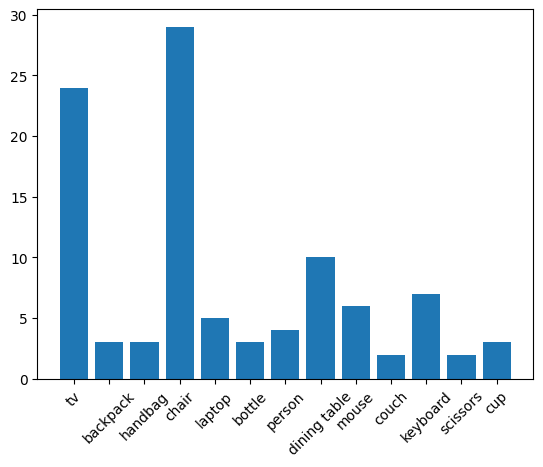

Total number of objects: 101


In [22]:
from collections import Counter

objects_counter = Counter()

for scene in DATA:
    for gt in DATA[scene]['gt']:
        objects_counter[gt.label] += 1

objects_counter
        
plt.bar(objects_counter.keys(), objects_counter.values())
plt.xticks(rotation=45)
plt.show()
print(f"Total number of objects: {sum(objects_counter.values())}")

In [23]:
tot = sum(objects_counter.values())
objects_counter, f"tot: {tot}"

(Counter({'chair': 29,
          'tv': 24,
          'dining table': 10,
          'keyboard': 7,
          'mouse': 6,
          'laptop': 5,
          'person': 4,
          'backpack': 3,
          'handbag': 3,
          'bottle': 3,
          'cup': 3,
          'couch': 2,
          'scissors': 2}),
 'tot: 101')

In [24]:
weights = {obj:value/tot for obj, value in objects_counter.items()}
weights

{'tv': 0.2376237623762376,
 'backpack': 0.0297029702970297,
 'handbag': 0.0297029702970297,
 'chair': 0.2871287128712871,
 'laptop': 0.04950495049504951,
 'bottle': 0.0297029702970297,
 'person': 0.039603960396039604,
 'dining table': 0.09900990099009901,
 'mouse': 0.0594059405940594,
 'couch': 0.019801980198019802,
 'keyboard': 0.06930693069306931,
 'scissors': 0.019801980198019802,
 'cup': 0.0297029702970297}

In [25]:
from scipy.spatial import KDTree


def pointcloud_iou(pred_points, gt_points, epsilon=0.025):
    pred_pcd = o3d.geometry.PointCloud()
    pred_pcd.points = o3d.utility.Vector3dVector(pred_points)

    gt_pcd = o3d.geometry.PointCloud()
    gt_pcd.points = o3d.utility.Vector3dVector(gt_points)

    gt_pcd = gt_pcd.voxel_down_sample(voxel_size=epsilon)
    pred_pcd = pred_pcd.voxel_down_sample(voxel_size=epsilon)

    pred_points = np.asarray(pred_pcd.points)
    gt_points = np.asarray(gt_pcd.points)

    # Construct KD-trees for efficient nearest neighbor search
    pred_tree = KDTree(pred_points)
    gt_tree = KDTree(gt_points)

    # Find neighbors within tolerance (epsilon)
    pred_in_gt = pred_tree.query_ball_tree(gt_tree, 2 * epsilon)
    gt_in_pred = gt_tree.query_ball_tree(pred_tree, 2 * epsilon)
    intersection1, intersection2 = set(), set()

    for i, neighbors in enumerate(pred_in_gt):
        if len(neighbors) > 0:
            intersection1.add(i)
            intersection2.update(neighbors)
    for i, neighbors in enumerate(gt_in_pred):
        if len(neighbors) > 0:
            intersection2.add(i)
            intersection1.update(neighbors)

    # Compute intersection and union
    intersection = intersection1.intersection(intersection2)
    intersection = len(intersection)
    # Compute union (total number of points across both clouds)
    union = len(pred_points) + len(gt_points) - intersection
    # IoU calculation
    iou = intersection / union if union > 0 else 0

    return iou


def create_grid_and_calculate_iou(pred_points, gt_points, grid_size=0.1):
    """
    Create a 3D grid (cube) and calculate the Intersection over Union (IoU) for two point clouds.

    Parameters:
    - pred_points: numpy array of shape (N, 3) for predicted point cloud.
    - gt_points: numpy array of shape (N, 3) for ground truth point cloud.
    - grid_size: The size of each cell in the 3D grid (e.g., 0.05 meters).

    Returns:
    - IoU: Intersection over Union value.
    """
    # Compute grid indices based on absolute coordinates
    pred_indices = np.floor(pred_points / grid_size).astype(np.int32)
    gt_indices = np.floor(gt_points / grid_size).astype(np.int32)

    # Convert grid indices to sets of tuples for efficient comparison
    pred_set = set(map(tuple, pred_indices))
    gt_set = set(map(tuple, gt_indices))

    # Compute intersection and union
    intersection = pred_set & gt_set
    union = pred_set | gt_set

    iou = len(intersection) / len(union) if len(union) > 0 else 0.0
    dice = 2 * len(intersection) / (len(pred_set) + len(gt_set)) if len(pred_set) + len(gt_set) > 0 else 0.0
    return iou, dice


def pointcloud_iou_with_voxel_grids(pred_points, gt_points, voxel_size=0.05):
    pred_points = pred_points.copy()
    gt_points = gt_points.copy()
    min_bound = np.minimum(np.min(pred_points, axis=0), np.min(gt_points, axis=0))
    max_bound = np.maximum(np.max(pred_points, axis=0), np.max(gt_points, axis=0))
    pred_points -= min_bound
    gt_points -= min_bound
    grid_shape = np.ceil((max_bound - min_bound) / voxel_size).astype(int)

    grid = np.zeros(grid_shape)

    pred_indices = np.floor(pred_points / voxel_size).astype(np.int32)
    gt_indices = np.floor(gt_points / voxel_size).astype(np.int32)

    pred_indices = np.array(list(set(map(tuple, pred_indices))))
    gt_indices = np.array(list(set(map(tuple, gt_indices))))

    grid[pred_indices[:, 0], pred_indices[:, 1], pred_indices[:, 2]] = 1
    grid[gt_indices[:, 0], gt_indices[:, 1], gt_indices[:, 2]] += 1

    intersection = len(np.where(grid == 2)[0])
    union = len(np.where(grid > 0)[0])

    iou = intersection / union
    return iou


import scipy.ndimage as ndimage
def iou_voxel_grids_with_closing(pred_points, gt_points, voxel_size=0.05):
    def get_voxel_grids(pred_points, gt_points, voxel_size=0.05):
        pred_points = pred_points.copy()
        gt_points = gt_points.copy()
        min_bound = np.minimum(np.min(pred_points, axis=0), np.min(gt_points, axis=0))
        max_bound = np.maximum(np.max(pred_points, axis=0), np.max(gt_points, axis=0))
        pred_points -= min_bound
        gt_points -= min_bound
        grid_shape = np.ceil((max_bound - min_bound) / voxel_size).astype(int)

        pred_grid = np.zeros(grid_shape)
        gt_grid = np.zeros(grid_shape)

        pred_indices = np.floor(pred_points / voxel_size).astype(np.int32)
        gt_indices = np.floor(gt_points / voxel_size).astype(np.int32)

        pred_indices = np.array(list(set(map(tuple, pred_indices))))
        gt_indices = np.array(list(set(map(tuple, gt_indices))))

        pred_grid[pred_indices[:, 0], pred_indices[:, 1], pred_indices[:, 2]] = 1
        gt_grid[gt_indices[:, 0], gt_indices[:, 1], gt_indices[:, 2]] = 1

        return pred_grid, gt_grid

    try:
        pred_grid, gt_grid = get_voxel_grids(pred_points, gt_points, voxel_size)
        structuring_element = np.ones((2, 2, 2))

        # Perform 3D morphological closing (dilation followed by erosion)
        closed_pred_grid = ndimage.binary_closing(pred_grid, structure=structuring_element)
        closed_gt_grid = ndimage.binary_closing(gt_grid, structure=structuring_element)

        pred_points = np.argwhere(closed_pred_grid)
        gt_points = np.argwhere(closed_gt_grid)

        pred_points = set(map(tuple, pred_points))
        gt_points = set(map(tuple, gt_points))

        intersection = pred_points & gt_points
        union = pred_points | gt_points

        iou = len(intersection) / len(union) if len(union) > 0 else 0.0
        dice = 2 * len(intersection) / (len(pred_points) + len(gt_points)) if len(pred_points) + len(gt_points) > 0 else 0.0

        return iou, dice
    except Exception as e:
        print("using voxel grid iou")
        return create_grid_and_calculate_iou(pred_points, gt_points, voxel_size)

In [26]:
import matplotlib.pyplot as plt


# Associating GT and predicted objects
def compute_3d_iou_matrix(gt, pred, method = "boxes"):
    """
    Compute the 3D IoU matrix between GT and predicted objects.

    Parameters:
    - gt_boxes: list of GT OrientedBoundingBox objects.
    - pred_boxes: list of predicted OrientedBoundingBox objects.

    Returns:
    - numpy array: 2D array where element (i, j) is the IoU between GT object i and predicted object j.
    """
    assert method in ["boxes", "pcd"]
    iou_matrix = np.zeros((len(gt), len(pred)))
    for i, gt_obj in enumerate(gt):
        for j, pred_obj in enumerate(pred):
            try:
                if method == "boxes":
                    iou = compute_3d_IoU(gt_obj.bbox, pred_obj.bbox)
                elif method == "pcd":
                    #iou = pointcloud_iou(gt_obj.points, pred_obj.points, epsilon=0.025)
                    #iou = pointcloud_iou_with_voxel_grids(gt_obj.points, pred_obj.points, voxel_size=0.05)
                    #iou, dice = iou_voxel_grids_with_closing(gt_obj.points, pred_obj.points, voxel_size=0.05)
                    iou, dice = create_grid_and_calculate_iou(gt_obj.points, pred_obj.points, grid_size=0.1)
                    iou = dice
            except Exception as e:
                iou = 0
                print(e)
            iou_matrix[i, j] = iou
    return iou_matrix


def get_matches(gt_objects, pred_objects, iou_threshold=0.5):
    """
    Get the matched GT and predicted objects.
    returns:
     - matched_couples: list of dictionaries containing the matched GT and predicted objects and their IoU.
     - phantom_predictions: list of predicted objects that have no match.
     - missed_gt: list of GT objects that have no match.
    """

    iou_matrix = compute_3d_iou_matrix(gt_objects, pred_objects, method = "pcd")
    matches = []
    for i, j in zip(*np.where(iou_matrix > iou_threshold)):
        matches.append({"gt": i, "pred": j, "iou": iou_matrix[i, j]})
    matches = sorted(matches, key=lambda x: x["iou"], reverse=True)

    matched_gt = set()
    matched_preds = set()
    matched_couples = []
    for match in matches:
        if match["gt"] not in matched_gt and match["pred"] not in matched_preds:
            matched_gt.add(match["gt"])
            matched_preds.add(match["pred"])
            matched_couples.append(
                {
                    "gt": gt_objects[match["gt"]],
                    "pred": pred_objects[match["pred"]],
                    "iou": match["iou"],
                }
            )

    phantom_preds = [
        pred_objects[i] for i in range(len(pred_objects)) if i not in matched_preds
    ]
    missed_gt = [gt_objects[i] for i in range(len(gt_objects)) if i not in matched_gt]

    assert len(matched_couples) + len(phantom_preds) == len(pred_objects)
    assert len(matched_couples) + len(missed_gt) == len(gt_objects)

    return matched_couples, phantom_preds, missed_gt

matching_dict, phantom_preds_dict, missed_gt_dict = {}, {}, {}
for scene in DATA:
    gt_objects = DATA[scene]["gt"]
    pred_objects = DATA[scene]["pred"]
    matching_dict[scene], phantom_preds_dict[scene], missed_gt_dict[scene] = get_matches(gt_objects, pred_objects, IOU_THRESHOLD)

----


In [27]:
#custom_draw_geometry(*DATA[2].values())

In [28]:
scene = DATA[2]
gt_objects = scene["gt"]
pred_objects = scene["pred"]
matches, phantom, missing = get_matches(gt_objects, pred_objects, 0.0000001)
[m["iou"] for m in matches]

[0.8810572687224669,
 0.8741721854304636,
 0.8571428571428571,
 0.808695652173913,
 0.801007556675063,
 0.7523992322456814,
 0.7368421052631579,
 0.7326732673267327,
 0.7224669603524229,
 0.585635359116022]

In [47]:
match_gt = o3d.geometry.PointCloud()
match_pred = o3d.geometry.PointCloud()
phantom_cloud = o3d.geometry.PointCloud()
missed_cloud = o3d.geometry.PointCloud()

idx = 0
match_gt.points = o3d.utility.Vector3dVector(matches[idx]["gt"].points)
match_pred.points = o3d.utility.Vector3dVector(matches[idx]["pred"].points)
phantom_cloud.points = o3d.utility.Vector3dVector(phantom[0].points)
missed_cloud.points = o3d.utility.Vector3dVector(missing[1].points)

match_gt.paint_uniform_color([0, 1, 0])
match_pred.paint_uniform_color([1, 0, 0])
phantom_cloud.paint_uniform_color([0, 0, 1])
missed_cloud.paint_uniform_color([1, 0, 1])

phantom_cloud.translate([5, -1, 0])
missed_cloud.translate([0, 1, 0])
#match_pred.rotate(R.from_euler('xyz', [0, 0, 45], degrees=True).as_matrix(), center=[0, 0, 0])
#match_gt.rotate(R.from_euler('xyz', [0, 0, 45], degrees=True).as_matrix(), center=[0, 0, 0])
o3d.visualization.draw_geometries([match_gt, match_pred, phantom_cloud, missed_cloud])

In [50]:
def visualize_match_phantom_missed(match_gt, match_pred, phantom, missed):
    def get_spheres(pcd, radius=0.03):
        spheres = []
        for point in np.asarray(pcd.points):
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
            sphere.translate(point)
            sphere.paint_uniform_color(pcd.colors[0])
            spheres.append(sphere)
        return spheres

    vis = o3d.visualization.Visualizer()
    vis.create_window()

    tot_meshes = []
    match_gt = match_gt.voxel_down_sample(voxel_size=0.03)
    match_pred = match_pred.voxel_down_sample(voxel_size=0.03)
    phantom = phantom.voxel_down_sample(voxel_size=0.03)
    missed = missed.voxel_down_sample(voxel_size=0.03)

    # Set premium, dark colors with mixed tones
    # Define premium, dark colors
    dark_teal = [0.1, 0.3, 0.3]         # Dark teal
    deep_aubergine = [0.3, 0.1, 0.2]    # Deep aubergine

    # Apply colors to different object categories
    match_gt.paint_uniform_color(dark_teal)          # Dark teal for ground truth matches
    match_pred.paint_uniform_color(deep_aubergine)   # Deep aubergine for predicted matches
    phantom.paint_uniform_color(deep_aubergine)           # Dark teal for phantom predictions
    missed.paint_uniform_color(dark_teal)       # Deep aubergine for missed detections

    match_gt_obb =  oriented_bounding_box_numpy(np.asarray(match_gt.points))
    match_pred_obb =  oriented_bounding_box_numpy(np.asarray(match_pred.points))
    phantom_obb =  oriented_bounding_box_numpy(np.asarray(phantom.points))
    missed_obb =  oriented_bounding_box_numpy(np.asarray(missed.points))

    match_gt_obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(match_gt_obb))
    match_pred_obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(match_pred_obb))
    phantom_obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(phantom_obb))
    missed_obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(missed_obb))
    match_gt_obb.color = dark_teal
    match_pred_obb.color = deep_aubergine
    phantom_obb.color = deep_aubergine
    missed_obb.color = dark_teal

    match_gt_obb = add_bounding_box_with_thick_lines(vis, match_gt_obb)
    match_pred_obb = add_bounding_box_with_thick_lines(vis, match_pred_obb)
    phantom_obb = add_bounding_box_with_thick_lines(vis, phantom_obb)
    missed_obb = add_bounding_box_with_thick_lines(vis, missed_obb)

    tot_meshes.extend(match_gt_obb)
    tot_meshes.extend(match_pred_obb)
    tot_meshes.extend(phantom_obb)
    tot_meshes.extend(missed_obb)
    tot_meshes.extend(get_spheres(match_gt))
    tot_meshes.extend(get_spheres(match_pred))
    tot_meshes.extend(get_spheres(phantom))
    tot_meshes.extend(get_spheres(missed))

    mesh = o3d.geometry.TriangleMesh()
    for m in tot_meshes:
        mesh += m

    vis.add_geometry(mesh)
    vis.run()
    vis.destroy_window()
    return mesh

mesh = visualize_match_phantom_missed(match_gt, match_pred, phantom_cloud, missed_cloud)

In [77]:
def visualize_random_colored_pcds(pcd_arrays):
    def get_random_color():
        return np.random.uniform(0, 0.5, 3)

    def create_spheres_from_pcd(pcd, radius=0.03, color=[0, 1, 0]):
        spheres = []
        for point in np.asarray(pcd.points):
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
            sphere.translate(point)
            sphere.paint_uniform_color(color)
            spheres.append(sphere)
        return spheres

    def create_bounding_box_from_pcd(pcd):
        obb_points = oriented_bounding_box_numpy(np.asarray(pcd.points))
        obb = o3d.geometry.OrientedBoundingBox.create_from_points(
            o3d.utility.Vector3dVector(obb_points)
        )
        obb.color = get_random_color()
        return add_bounding_box_with_thick_lines(vis, obb)

    # Initialize visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    tot_meshes = []

    # Process each point cloud in the input list
    for pcd_array in pcd_arrays:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pcd_array)
        pcd = pcd.voxel_down_sample(voxel_size=0.05)
        pcd.paint_uniform_color(get_random_color())

        # Create spheres and bounding boxes
        color = get_random_color()
        spheres = create_spheres_from_pcd(pcd, radius = 0.02, color=color)
        bounding_box = create_bounding_box_from_pcd(pcd)

        # Add bounding box and spheres to the total mesh
        tot_meshes.extend(bounding_box)
        tot_meshes.extend(spheres)

    # Combine all meshes and add to the visualizer
    combined_mesh = o3d.geometry.TriangleMesh()
    for mesh in tot_meshes:
        combined_mesh += mesh

    vis.add_geometry(combined_mesh)
    vis.run()
    vis.destroy_window()

    return combined_mesh

pcds = [match['gt'].points for match in matches]

mesh = visualize_random_colored_pcds(pcds)

In [78]:
o3d.io.write_triangle_mesh("final_scene.glb", mesh)

True

In [36]:
o3d.visualization.draw_geometries([mesh])

In [ ]:
o3d.visu

In [82]:
idx = 0
matches[idx]['gt']
pred = o3d.geometry.PointCloud()
pred.points = o3d.utility.Vector3dVector(matches[idx]['pred'].points)
gt = o3d.geometry.PointCloud()
gt.points = o3d.utility.Vector3dVector(matches[idx]['gt'].points)
pred.paint_uniform_color([1, 0, 0])
gt.paint_uniform_color([0, 1, 0])
o3d.visualization.draw_geometries([pred, gt])

In [83]:
gt_points = matches[idx]['gt'].points
pred_points = matches[idx]['pred'].points

#save to file
np.savetxt(f"gt_points_{matches[idx]['gt'].label}.txt", gt_points)
np.savetxt(f"pred_points_{matches[idx]['gt'].label}.txt", pred_points)

In [29]:
idx = 5
obj2 = matches[idx]["pred"]
obj1 = matches[idx]["gt"]
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(obj1.points)
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(obj2.points)

iou, dice = iou_voxel_grids_with_closing(obj1.points, obj2.points, voxel_size=0.05)
print(f"IoU: {iou}, Dice: {dice}")

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(obj1.points)
pcd1.colors = o3d.utility.Vector3dVector(np.array([[1, 0, 0]] * len(obj1.points)))
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(obj2.points)
pcd2.colors = o3d.utility.Vector3dVector(np.array([[0, 1, 0]] * len(obj2.points)))
o3d.visualization.draw_geometries([pcd1, pcd2])

IoU: 0.5128205128205128, Dice: 0.6779661016949152


In [154]:
def create_colored_voxel_grid(cube_grid, grid_size, voxel_size=0.03):
    """
    Create and visualize a voxel grid from a 3D numpy cube grid with values 1 or 2, coloring the voxels accordingly.

    Parameters:
    - cube_grid: 3D numpy array representing the grid. Values should be 0 (empty), 1, or 2.
    - grid_size: Tuple (nx, ny, nz) indicating the size of the cube grid in each dimension.
    - voxel_size: The size of each voxel.
    
    Returns:
    - voxel_grid: An Open3D voxel grid object with colored voxels.
    """
    # Create a list of
    # voxel centers and colors
    voxel_centers = []
    voxel_colors = []

    # Color mapping
    color_map = {1: [1, 0, 0],  # Red for value 1
                 2: [0, 1, 0]}  # Green for value 2

    # Iterate through the cube grid and create voxels where grid value is 1 or 2
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            for z in range(grid_size[2]):
                if cube_grid[x, y, z] > 0:  # Only create voxels for grid values 1 or 2
                    voxel_centers.append([x * voxel_size, y * voxel_size, z * voxel_size])
                    voxel_colors.append(color_map[cube_grid[x, y, z]])

    # Convert voxel centers and colors to Open3D point cloud format
    voxel_centers = np.array(voxel_centers)
    voxel_colors = np.array(voxel_colors)

    # Create an Open3D point cloud from the voxel centers
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(voxel_centers)
    pcd.colors = o3d.utility.Vector3dVector(voxel_colors)

    # Create a voxel grid from the point cloud
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)

    return voxel_grid

voxel_grid = create_colored_voxel_grid(grid, grid_shape, voxel_size=grid_size)
o3d.visualization.draw_geometries([voxel_grid])

NameError: name 'grid' is not defined

In [77]:
ious = [match["iou"] for match in matches]
np.mean(ious)

NameError: name 'matches' is not defined

----

In [26]:
scene = 4
print("GT objects that have no match: ", len(missed_gt_dict[scene]))
print("Predicted objects that have no match: ", len(phantom_preds_dict[scene]))
custom_draw_geometry(DATA[scene]["pointcloud"], missed_gt_dict[scene], phantom_preds_dict[scene])

GT objects that have no match:  1
Predicted objects that have no match:  7


In [27]:
matching, phantom_preds, missed_gt = [], [], []
for scene in DATA:
    matching.extend(matching_dict[scene])
    phantom_preds.extend(phantom_preds_dict[scene])
    missed_gt.extend(missed_gt_dict[scene])

In [28]:
def compute_average_distance(matching):
    distances = []
    for match in matching:
        gt_points = match["gt"].points
        pred_points = match["pred"].points
        
        gt_centroid = np.mean(gt_points, axis=0)
        pred_centroid = np.mean(pred_points, axis=0)
        distances.append(np.linalg.norm(gt_centroid - pred_centroid))

    return np.mean(distances)

In [29]:
np.mean([match["iou"] for match in matching])

0.6888024084895428

In [30]:
len(matching), len(phantom_preds), len(missed_gt)

(93, 18, 8)

In [132]:
#dataset = {}
#i = 0
#for match in matching:
#    pred = match["pred"]
#    gt = match["gt"]
#    #dataset[i] = {"points": list(pred.points.flatten()), "label": gt.label, "box": list(gt.box_feat.flatten())}
#    #i += 1
#    dataset[i] = {"points": list(gt.points.flatten()), "label": gt.label, "box": list(gt.box_feat.flatten())}
#    i += 1
#last_id = max(dataset.keys()) + 1
#
#for i, obj in enumerate(missed_gt, start=last_id):
#    dataset[i] = {"points": list(obj.points.flatten()), "label": obj.label, "box": list(obj.box_feat.flatten())}
#

In [133]:
#json.dump(dataset, open("gt_dataset2.json", "w"))

In [134]:
#filter_labels = ["chair", "tv"]
#matching = [match for match in matching if match["gt"].label in filter_labels]
#phantom_preds = [pred for pred in phantom_preds if pred.label in filter_labels]
#missed_gt = [gt for gt in missed_gt if gt.label in filter_labels]
#label2idx = {label: idx for idx, label in enumerate(filter_labels)}
#idx2label = {idx: label for label, idx in label2idx.items()}

In [32]:
def compute_confusion_matrix(matches, phantom_preds, missed_gt, label2idx, score_threshold=0.5):
    num_classes = len(label2idx)
    conf_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)
    
    for match in matches:
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        if score >= score_threshold:
            conf_matrix[gt_idx, pred_idx] += 1
        else:
            conf_matrix[gt_idx, num_classes] += 1  # FN
            conf_matrix[num_classes, pred_idx] += 1  # FP
    
    for missed in missed_gt:
        gt_idx = label2idx[missed.label]
        conf_matrix[gt_idx, num_classes] += 1
    
    for phantom in phantom_preds:
        pred_idx = label2idx[phantom.label]
        conf_matrix[num_classes, pred_idx] += 1

    return conf_matrix

conf_matrix = compute_confusion_matrix(matching, phantom_preds, missed_gt, label2idx, 0.9)
#conf_matrix

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics_from_confusion_matrix(conf_matrix, num_classes):
    y_true = []
    y_pred = []
    
    for i in range(num_classes + 1):
        for j in range(num_classes + 1):
            y_true.extend([i] * conf_matrix[i, j])
            y_pred.extend([j] * conf_matrix[i, j])
    
    precision = precision_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    recall = recall_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    f1 = f1_score(y_true, y_pred, average=None, labels=range(num_classes + 1), zero_division=1)
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    
    return precision[:-1], recall[:-1], f1[:-1], accuracy

precision, recall, f1, accuracy = compute_metrics_from_confusion_matrix(conf_matrix, len(label2idx))
#precision, recall, f1, accuracy

In [34]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

def MAP(matching, phantom_preds, missed_gt, label2idx):
    n_samples = len(matching) + len(phantom_preds) + len(missed_gt)
    num_classes = len(label2idx)
    Y_true = np.zeros((n_samples, num_classes + 1), dtype=bool)
    Y_pred = np.zeros((n_samples, num_classes + 1), dtype=np.float32)

    for i, match in enumerate(matching):
        gt_idx = label2idx[match['gt'].label]
        pred_idx = label2idx[match['pred'].label]
        score = match['pred'].score

        Y_true[i, gt_idx] = True
        Y_pred[i, pred_idx] = score
    
    for i, missed in enumerate(missed_gt):
        gt_idx = label2idx[missed.label]
        Y_true[i + len(matching), gt_idx] = True
        Y_pred[i + len(matching), num_classes] = 0.0
    
    for i, phantom in enumerate(phantom_preds):
        pred_idx = label2idx[phantom.label]
        Y_pred[i + len(matching) + len(missed_gt), pred_idx] = phantom.score
        Y_true[i + len(matching) + len(missed_gt), num_classes] = True 
    
    precisions, recalls, thresholds = precision_recall_curve(Y_true.ravel(), Y_pred.ravel())
    
    MAP = average_precision_score(Y_true, Y_pred, average='weighted')
    return MAP, precisions, recalls, thresholds

mean_ap, precisions, recalls, thresholds = MAP(matching, phantom_preds, missed_gt, label2idx)
print(f"The mean Average Precision is: {mean_ap:.3f}")

The mean Average Precision is: 0.726


/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [41]:
def compute_mAP(matching, phantom_preds, missed_gt, label2idx):
    AP_per_class = {}

    for label in label2idx:
        # Collect predictions for this class
        preds_for_class = []
        gt_for_class = []
        num_gt = 0

        # Ground truths for this class
        gt_labels = set()

        # Process matching entries
        for match in matching:
            gt_label = match["gt"].label
            pred_label = match["pred"].label
            pred_score = match["pred"].score

            if gt_label == label:
                num_gt += 1
                gt_id = id(match["gt"])
                gt_labels.add(gt_id)
                if pred_label == label:
                    # True Positive
                    preds_for_class.append({"score": pred_score, "match": 1})
                else:
                    # Misclassified prediction; not a TP for this class
                    pass

            elif pred_label == label:
                # False Positive for this class
                preds_for_class.append({"score": pred_score, "match": 0})

        # Process phantom predictions (False Positives)
        for pred in phantom_preds:
            if pred.label == label:
                preds_for_class.append({"score": pred.score, "match": 0})

        # Count missed ground truths
        num_gt += sum(1 for gt in missed_gt if gt.label == label)

        if num_gt == 0:
            continue  # Skip classes with no ground truths

        if not preds_for_class:
            AP_per_class[label] = {"AP": 0.0, "precision": [0.0], "recall": [0.0], "thresholds": [0.0]}
            continue

        # Sort predictions by score
        preds_for_class.sort(key=lambda x: x["score"], reverse=True)
        # Compute cumulative true positives and false positives
        tp = np.array([p["match"] for p in preds_for_class])
        fp = 1 - tp
        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)


        # Compute precision and recall
        precisions = cum_tp / (cum_tp + cum_fp)
        recalls = cum_tp / num_gt

        # Insert initial values
        precisions = np.concatenate(([0.0], precisions))
        recalls = np.concatenate(([0.0], recalls))
        # Ensure precision is non-increasing
        for i in range(len(precisions) - 1, 0, -1):
            precisions[i - 1] = max(precisions[i - 1], precisions[i])

        # Compute AP
        AP = np.sum((recalls[1:] - recalls[:-1]) * precisions[1:])
        AP_per_class[label] = {
            "AP": AP,
            "precision": precisions.tolist(),
            "recall": recalls.tolist(),
            "thresholds": [0.0] + [p["score"] for p in preds_for_class]
        }

    # Compute mean AP
    # mAP = np.mean(list(AP_per_class.values())) if AP_per_class else 0.0
    mAP = np.median([AP_per_class[label]["AP"] for label in AP_per_class])

    #given weights dict where weights['chair] = 0.29 and sum(weights.values()) = 1, compute weighted mAP
    weighted_mAP = np.sum([AP_per_class[label]["AP"] * weights[label] for label in AP_per_class])
    
    return mAP, AP_per_class, weighted_mAP


mAP, AP_per_class, weighted_mAP = compute_mAP(matching, phantom_preds, missed_gt, label2idx)
mAP, weighted_mAP

(0.0, 0.0)

In [37]:
for label in AP_per_class:
    print(f"Class: {label}, AP: {AP_per_class[label]['AP']:.3f}")

Class: tv, AP: 0.992
Class: backpack, AP: 1.000
Class: handbag, AP: 0.667
Class: chair, AP: 0.891
Class: laptop, AP: 1.000
Class: bottle, AP: 0.833
Class: person, AP: 1.000
Class: dining table, AP: 0.300
Class: mouse, AP: 0.722
Class: couch, AP: 1.000
Class: keyboard, AP: 0.621
Class: scissors, AP: 0.500
Class: cup, AP: 1.000


In [142]:
mAP = np.median([AP_per_class[label]["AP"] for label in AP_per_class if AP_per_class[label]["AP"] > 0.03])
mAP

0.8914614121510673

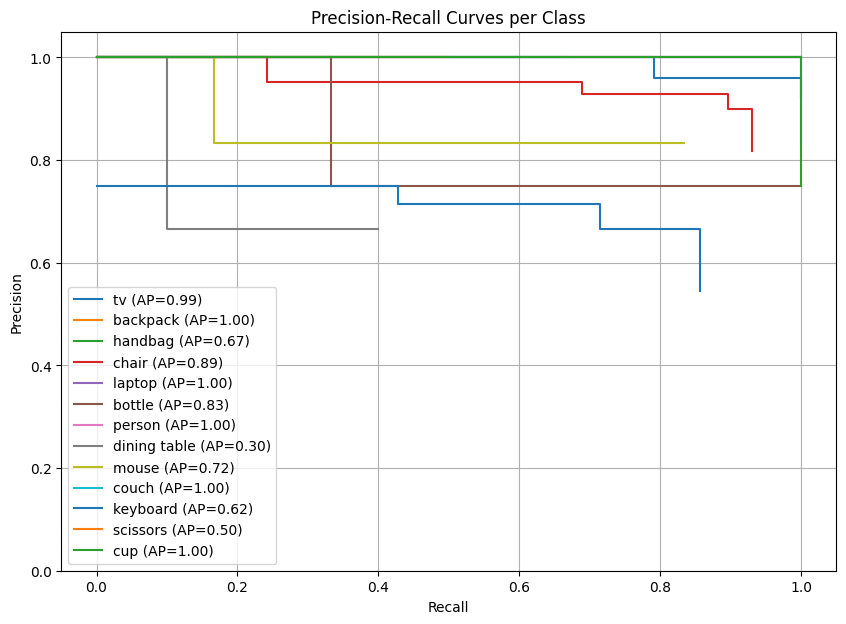

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

for label in AP_per_class:
    precision = AP_per_class[label]['precision']
    recall = AP_per_class[label]['recall']
    plt.step(recall, precision, where='post', label=f'{label} (AP={AP_per_class[label]["AP"]:.2f})')

plt.title('Precision-Recall Curves per Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.show()

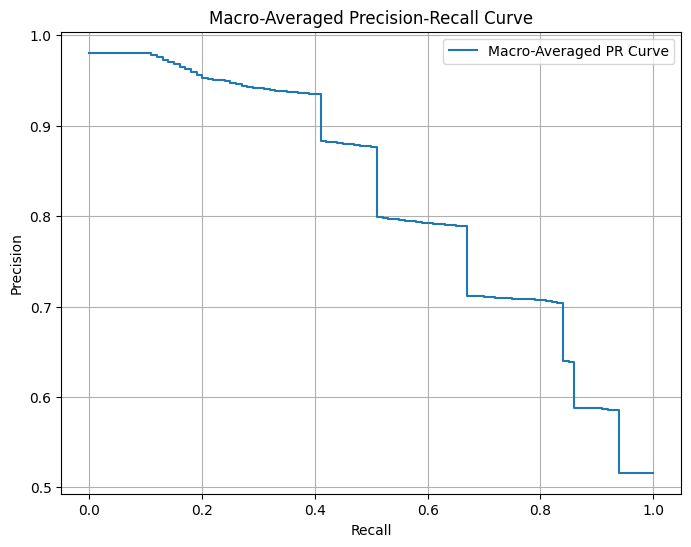

In [144]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Define common recall levels
recall_levels = np.linspace(0, 1, 101)

# Collect interpolated precision values for each class
interpolated_precisions = []

for label in AP_per_class:
    precision = np.array(AP_per_class[label]['precision'])
    recall = np.array(AP_per_class[label]['recall'])
    # Ensure recall is monotonically increasing
    recall, unique_indices = np.unique(recall, return_index=True)
    precision = precision[unique_indices]
    # Interpolate precision values
    interp_func = interp1d(recall, precision, kind='linear', bounds_error=False, fill_value=(precision[0], 0.0))
    interpolated_precision = interp_func(recall_levels)
    interpolated_precisions.append(interpolated_precision)

# Compute mean precision at each recall level
mean_precision = np.mean(interpolated_precisions, axis=0)

# Plot the macro-averaged precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall_levels, mean_precision, where='post', label='Macro-Averaged PR Curve')
plt.title('Macro-Averaged Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

In [194]:
object_category = {
    'couch': 'big',
    'person': 'big',
    'chair': 'big',
    'tv': 'big',
    'dining table': 'medium',
    'laptop': 'medium',
    'keyboard': 'medium',
    'backpack': 'medium',
    'handbag': 'medium',
    'bottle': 'small',
    'mouse': 'small',
    'cup': 'small',
    'scissors': 'small'
}

In [214]:
len(matching), len(phantom_preds), len(missed_gt)

(0, 111, 101)

In [38]:
from tqdm import tqdm

iou_thresholds = np.linspace(0.05, 1, 20)
maps = []
w_maps = []
aLP = dict()
AP_per_class_thr = dict()
avg_distances = []
for thr in tqdm(iou_thresholds):
    matching_dict, phantom_preds_dict, missed_gt_dict = {}, {}, {}
    for scene in DATA:
        gt_objects = DATA[scene]["gt"]
        pred_objects = DATA[scene]["pred"]
        matching_dict[scene], phantom_preds_dict[scene], missed_gt_dict[scene] = get_matches(gt_objects, pred_objects, thr)
    matching, phantom_preds, missed_gt = [], [], []
    for scene in DATA:
        matching.extend(matching_dict[scene])
        phantom_preds.extend(phantom_preds_dict[scene])
        missed_gt.extend(missed_gt_dict[scene])
    
    avg_distances.append(compute_average_distance(matching))

    if matching:
        lp = np.array([(match["iou"], match['gt'].label) for match in matching])
        lp = np.concatenate([lp, np.array([(0, gt.label) for gt in missed_gt])])
        lp = np.concatenate([lp, np.array([(0, pred.label) for pred in phantom_preds])])
        aLP[thr] = lp
    
    mean_ap, AP_per_class, weighted_mAP = compute_mAP(matching, phantom_preds, missed_gt, label2idx)
    maps.append(mean_ap)
    w_maps.append(weighted_mAP)
    AP_per_class_thr[thr] = AP_per_class
    


 90%|█████████ | 18/20 [01:56<00:12,  6.46s/it]/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20/20 [02:09<00:00,  6.48s/it]


In [39]:
for thr in AP_per_class_thr:
    print(f"Threshold: {thr}")
    for label in AP_per_class_thr[thr]:
        print(f"Class: {label}, AP: {AP_per_class_thr[thr][label]['AP']:.3f}")

Threshold: 0.05
Class: tv, AP: 0.992
Class: backpack, AP: 1.000
Class: handbag, AP: 0.667
Class: chair, AP: 0.891
Class: laptop, AP: 1.000
Class: bottle, AP: 0.833
Class: person, AP: 1.000
Class: dining table, AP: 0.300
Class: mouse, AP: 0.722
Class: couch, AP: 1.000
Class: keyboard, AP: 0.621
Class: scissors, AP: 0.500
Class: cup, AP: 1.000
Threshold: 0.1
Class: tv, AP: 0.906
Class: backpack, AP: 1.000
Class: handbag, AP: 0.667
Class: chair, AP: 0.891
Class: laptop, AP: 1.000
Class: bottle, AP: 0.833
Class: person, AP: 1.000
Class: dining table, AP: 0.300
Class: mouse, AP: 0.722
Class: couch, AP: 1.000
Class: keyboard, AP: 0.621
Class: scissors, AP: 0.500
Class: cup, AP: 1.000
Threshold: 0.15
Class: tv, AP: 0.906
Class: backpack, AP: 1.000
Class: handbag, AP: 0.667
Class: chair, AP: 0.891
Class: laptop, AP: 1.000
Class: bottle, AP: 0.833
Class: person, AP: 1.000
Class: dining table, AP: 0.300
Class: mouse, AP: 0.722
Class: couch, AP: 1.000
Class: keyboard, AP: 0.621
Class: scissors, A

In [40]:
for i, thr in enumerate(iou_thresholds):
    print(f"MaP@{thr:.2f}: {maps[i]:.3f}, wAP@{thr:.2f}: {w_maps[i]:.3f}")

MaP@0.05: 0.810, wAP@0.05: 0.830
MaP@0.10: 0.803, wAP@0.10: 0.810
MaP@0.15: 0.803, wAP@0.15: 0.810
MaP@0.20: 0.803, wAP@0.20: 0.810
MaP@0.25: 0.803, wAP@0.25: 0.810
MaP@0.30: 0.803, wAP@0.30: 0.810
MaP@0.35: 0.799, wAP@0.35: 0.796
MaP@0.40: 0.799, wAP@0.40: 0.796
MaP@0.45: 0.770, wAP@0.45: 0.740
MaP@0.50: 0.758, wAP@0.50: 0.728
MaP@0.55: 0.744, wAP@0.55: 0.716
MaP@0.60: 0.682, wAP@0.60: 0.638
MaP@0.65: 0.581, wAP@0.65: 0.560
MaP@0.70: 0.405, wAP@0.70: 0.414
MaP@0.75: 0.316, wAP@0.75: 0.347
MaP@0.80: 0.079, wAP@0.80: 0.179
MaP@0.85: 0.030, wAP@0.85: 0.037
MaP@0.90: 0.000, wAP@0.90: 0.001
MaP@0.95: 0.000, wAP@0.95: 0.000
MaP@1.00: 0.000, wAP@1.00: 0.000


MaP@0.05: 0.810
MaP@0.10: 0.803
MaP@0.15: 0.803
MaP@0.20: 0.803
MaP@0.25: 0.803
MaP@0.30: 0.803
MaP@0.35: 0.799
MaP@0.40: 0.799
MaP@0.45: 0.770
MaP@0.50: 0.758
MaP@0.55: 0.744
MaP@0.60: 0.682
MaP@0.65: 0.581
MaP@0.70: 0.405
MaP@0.75: 0.316
MaP@0.80: 0.079
MaP@0.85: 0.030
MaP@0.90: 0.000
MaP@0.95: 0.000
MaP@1.00: 0.000

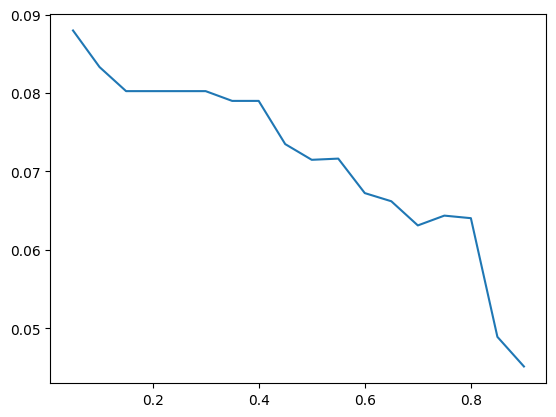

In [162]:
plt.plot(iou_thresholds, avg_distances)

In [ ]:
#IoU
MaP@0.05: 0.803
MaP@0.10: 0.803
MaP@0.15: 0.797
MaP@0.20: 0.754
MaP@0.25: 0.700
MaP@0.30: 0.640
MaP@0.35: 0.615
MaP@0.40: 0.548
MaP@0.45: 0.354
MaP@0.50: 0.316
MaP@0.55: 0.206
MaP@0.60: 0.065
MaP@0.65: 0.010
MaP@0.70: 0.003
MaP@0.75: 0.000
MaP@0.80: 0.000
MaP@0.85: 0.000
MaP@0.90: 0.000
MaP@0.95: 0.000
MaP@1.00: 0.000

In [ ]:
#DICE
MaP@0.05: 0.803
MaP@0.10: 0.803
MaP@0.15: 0.803
MaP@0.20: 0.803
MaP@0.25: 0.801
MaP@0.30: 0.797
MaP@0.35: 0.754
MaP@0.40: 0.712
MaP@0.45: 0.640
MaP@0.50: 0.630
MaP@0.55: 0.553
MaP@0.60: 0.364
MaP@0.65: 0.328
MaP@0.70: 0.265
MaP@0.75: 0.065
MaP@0.80: 0.008
MaP@0.85: 0.002
MaP@0.90: 0.000
MaP@0.95: 0.000
MaP@1.00: 0.000

tv: [0.992 0.906 0.906 0.906 0.906 0.906 0.906 0.906 0.826 0.826 0.826 0.64
 0.598 0.477 0.397 0.225 0.043 0.002 0.    0.   ]
chair: [0.891 0.891 0.891 0.891 0.891 0.891 0.844 0.844 0.782 0.782 0.782 0.754
 0.692 0.603 0.543 0.376 0.049 0.002 0.    0.   ]
keyboard: [0.621 0.621 0.621 0.621 0.621 0.621 0.621 0.621 0.482 0.317 0.143 0.079
 0.079 0.079 0.016 0.016 0.016 0.    0.    0.   ]
mouse: [0.722 0.722 0.722 0.722 0.722 0.722 0.722 0.722 0.722 0.722 0.722 0.528
 0.528 0.167 0.056 0.056 0.056 0.    0.    0.   ]
cup: [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    0.167 0.167 0.    0.    0.   ]


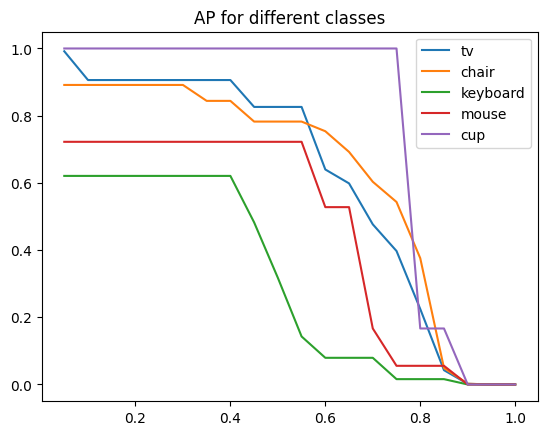

In [169]:
classes = ["tv", "chair", "keyboard", "mouse", "cup"]
#classes = list(AP_per_class_thr[0.05].keys())
#compute mAP for each class
for i, label in enumerate(classes):
    APs = [AP_per_class_thr[thr][label]["AP"] for thr in iou_thresholds]
    print(f"{label}: {np.round(APs, 3)}")
    plt.plot(iou_thresholds, APs, label=label)

plt.title("AP for different classes")
plt.legend()

tv: Precisions: [[1.0, 1.0, 1.0, 1.0, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9047619047619048, 0.9047619047619048, 0.8695652173913043, 0.8695652173913043, 0.84, 0.84, 0.8076923076923077]], Recalls: [[0.0, 0.041666666666666664, 0.08333333333333333, 0.125, 0.125, 0.16666666666666666, 0.20833333333333334, 0.25, 0.2916666666666667, 0.3333333333333333, 0.375, 0.4166666666666667, 0.4583333333333333, 0.5, 0.5416666666666666, 0.5833333333333334, 0.625, 0.6666666666666666, 0.7083333333333334, 0.75, 0.75, 0.7916666666666666, 0.7916666666666666, 0.8333333333333334, 0.8333333333333334, 0.875, 0.875]]
chair: Precisions: [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 

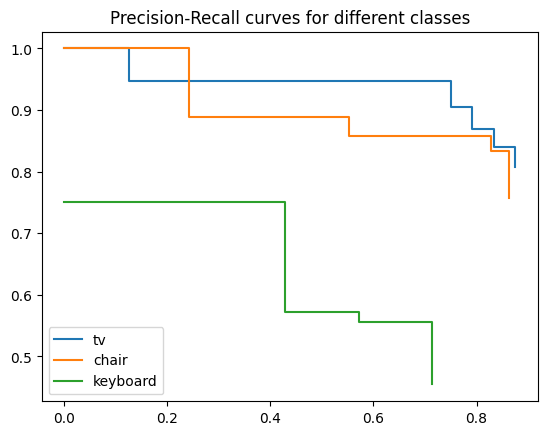

In [118]:
thr = 0.44999999999999996
#thr = 0.05
for i, label in enumerate(classes):
    precisions = [AP_per_class_thr[thr][label]["precision"]]
    recalls = [AP_per_class_thr[thr][label]["recall"]]
    print(f"{label}: Precisions: {precisions}, Recalls: {recalls}")
    plt.plot(recalls[0], precisions[0], label=label)

plt.title("Precision-Recall curves for different classes")
plt.legend()
plt.show()

In [247]:
n_obj = 93
aLP

{0.05: array([['0.8080229226361032', 'tv'],
        ['0.7669172932330827', 'backpack'],
        ['0.6949152542372882', 'laptop'],
        ['0.6808510638297872', 'handbag'],
        ['0.6629213483146067', 'chair'],
        ['0.6575342465753424', 'laptop'],
        ['0.653179190751445', 'person'],
        ['0.650887573964497', 'tv'],
        ['0.5833333333333334', 'bottle'],
        ['0.8888888888888888', 'mouse'],
        ['0.8448275862068966', 'tv'],
        ['0.7902097902097902', 'tv'],
        ['0.7818181818181819', 'couch'],
        ['0.7611336032388664', 'chair'],
        ['0.7368421052631579', 'scissors'],
        ['0.6511627906976745', 'handbag'],
        ['0.6299212598425197', 'dining table'],
        ['0.6197183098591549', 'laptop'],
        ['0.6190476190476191', 'backpack'],
        ['0.6153846153846154', 'bottle'],
        ['0.47619047619047616', 'keyboard'],
        ['0.1103448275862069', 'dining table'],
        ['0.8810572687224669', 'chair'],
        ['0.8741721854304636

In [255]:
len(aLP[0.05])

120

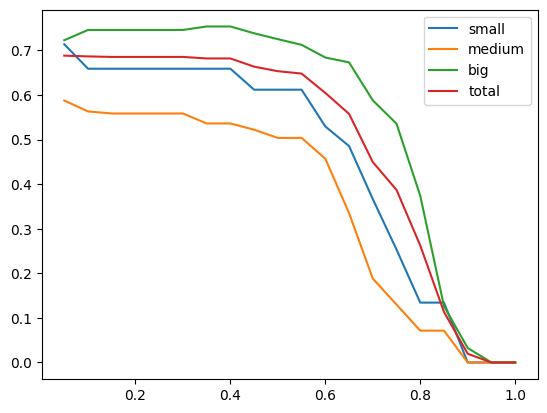

In [257]:
aLP_dict = aLP.copy()
smalls, mediums, bigs, tot = [], [], [], []
for thr, lp in aLP_dict.items():
    LP = lp[:n_obj, :].copy()
    LP[:, 1] = [object_category[label] for label in LP[:, 1]]

    small = np.mean(LP[LP[:, 1] == 'small', 0].astype(np.float32))
    medium = np.mean(LP[LP[:, 1] == 'medium', 0].astype(np.float32))
    big = np.mean(LP[LP[:, 1] == 'big', 0].astype(np.float32))
    tot.append(np.mean(LP[:, 0].astype(np.float32)))
    smalls.append(small)
    mediums.append(medium)
    bigs.append(big)

smalls = np.concatenate([smalls, [0]*len(iou_thresholds[len(smalls):])])
mediums = np.concatenate([mediums, [0]*len(iou_thresholds[len(mediums):])])
bigs = np.concatenate([bigs, [0]*len(iou_thresholds[len(bigs):])])
tot = np.concatenate([tot, [0]*len(iou_thresholds[len(tot):])])

plt.plot(iou_thresholds, smalls, label='small')
plt.plot(iou_thresholds, mediums, label='medium')
plt.plot(iou_thresholds, bigs, label='big')
plt.plot(iou_thresholds, tot, label='total')

plt.legend()

In [266]:
print(f"Small: {smalls}")
print(f"Medium: {mediums}")
print(f"Big: {bigs}")
print(f"Total: {tot}")
print(f"Dice threshold: {aLP.keys()}")

Small: [0.71405149 0.65912443 0.65912443 0.65912443 0.65912443 0.65912443
 0.65912443 0.65912443 0.61204416 0.61204416 0.61204416 0.5295611
 0.48560503 0.36667112 0.2533108  0.13431014 0.13431014 0.
 0.         0.        ]
Medium: [0.58774042 0.5632512  0.55865353 0.55865353 0.55865353 0.55865353
 0.53630739 0.53630739 0.522232   0.50377351 0.50394499 0.45718965
 0.33509052 0.18828426 0.12988642 0.07142857 0.07142857 0.
 0.         0.        ]
Big: [0.72310168 0.74609047 0.74609047 0.74609047 0.74609047 0.74609047
 0.7538839  0.7538839  0.73862886 0.72543901 0.71271199 0.68426085
 0.67336726 0.58812505 0.53577209 0.37410218 0.12652875 0.03246252
 0.         0.        ]
Total: [0.68845737 0.68674964 0.68556315 0.68556315 0.68556315 0.68556315
 0.68214959 0.68214959 0.66372871 0.6535483  0.64817196 0.6048153
 0.5578047  0.44968504 0.38717917 0.26247355 0.11339706 0.01954732
 0.         0.        ]
Dice threshold: dict_keys([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44

In [268]:
#let's extract the system macro precision and recall at each overlap threshold
precisions, recalls = [], []
for thr, values in AP_per_class_thr.items():
    precisions.append(np.mean([values[label]["precision"][-1] for label in classes]))
    recalls.append(np.mean([values[label]["recall"][-1] for label in classes]))


f1_scores = 2 * np.array(precisions) * np.array(recalls) / (np.array(precisions) + np.array(recalls))
f1_scores, AP_per_class_thr.keys()

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_76394/4087748820.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * np.array(precisions) * np.array(recalls) / (np.array(precisions) + np.array(recalls))


(array([0.84250562, 0.8264672 , 0.8264672 , 0.8264672 , 0.8264672 ,
        0.8264672 , 0.82001154, 0.82001154, 0.78289469, 0.76022808,
        0.73753347, 0.65080138, 0.63633663, 0.53223842, 0.44704839,
        0.28252793, 0.17143869, 0.01445377,        nan,        nan]),
 dict_keys([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0]))

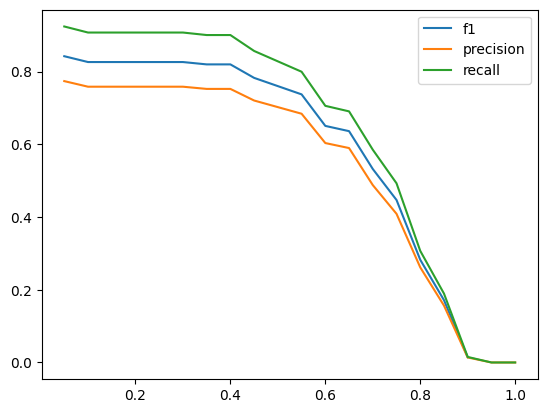

In [269]:
plt.plot(iou_thresholds, f1_scores, label = "f1")
plt.plot(iou_thresholds, precisions, label = "precision")
plt.plot(iou_thresholds, recalls, label = "recall")
plt.legend()

In [264]:
print(f"X (dice_thresholds): {iou_thresholds}")
print(f"Y (f1_scores): {np.round(f1_scores, 2)}")
print(f"Y (precisions): {np.round(precisions, 2)}")
print(f"Y (recalls): {np.round(recalls, 2)}")

X (dice_thresholds): [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
Y (f1_scores): [0.84 0.83 0.83 0.83 0.83 0.83 0.82 0.82 0.78 0.76 0.74 0.65 0.64 0.53
 0.45 0.28 0.17 0.01  nan  nan]
Y (precisions): [0.77 0.76 0.76 0.76 0.76 0.76 0.75 0.75 0.72 0.7  0.68 0.6  0.59 0.49
 0.41 0.26 0.16 0.01 0.   0.  ]
Y (recalls): [0.92 0.91 0.91 0.91 0.91 0.91 0.9  0.9  0.86 0.83 0.8  0.71 0.69 0.59
 0.49 0.31 0.19 0.02 0.   0.  ]


In [45]:
a = "0.84 0.83 0.83 0.83 0.83 0.83 0.82 0.82 0.78 0.76 0.74 0.65 0.64 0.53 0.45 0.28 0.17 0.01  nan  nan"
a = a.replace(".", ",")
a = a.replace("nan", "0")
a = a.split()
for s in a:
    print(s)


0,84
0,83
0,83
0,83
0,83
0,83
0,82
0,82
0,78
0,76
0,74
0,65
0,64
0,53
0,45
0,28
0,17
0,01
0
0


0,84
0,83
0,83
0,83
0,83
0,83
0,82
0,82
0,78
0,76
0,74
0,65
0,64
0,53
0,45
0,28
0,17
0,01
0
0

In [275]:
precisions[7], recalls[7], f1_scores[7], maps[7]

(0.7525641025641026,
 0.9007389162561577,
 0.8200115362283409,
 0.7994685519615911)

In [276]:
print(f"Precision: {precisions[7]:.3f}")
print(f"Recall: {recalls[7]:.3f}")
print(f"F1: {f1_scores[7]:.3f}")
print(f"mAP: {maps[7]:.3f}")


Precision: 0.753
Recall: 0.901
F1: 0.820
mAP: 0.799


In [278]:
def print_pyramid(n:int):
    for i in range(n):
        s = "*"*i
        print(f"{s : ^n}")

print_pyramid(4)

ValueError: Unknown format code 'n' for object of type 'str'

In [1]:
import os
import json
import numpy as np

In [19]:
folder = "../WCET_real_time_no_service"
data = dict()
for file in os.listdir(folder):
    if file.endswith(".json"):
        content = json.load(open(os.path.join(folder, file)))
        key = "_".join(file.split("_")[:-4])
        data[key] = content[key]["time"]

In [20]:
means = dict()
for key, time in data.items():
    means[key] = np.mean(time)
    print(f"{key}, mean_time: {np.mean(time):.3f}, std_time: {np.std(time):.3f}")

compute_3d_iou, mean_time: 0.001, std_time: 0.001
handle_clean_up, mean_time: 0.002, std_time: 0.003
obj_callback, mean_time: 0.044, std_time: 0.026
detection_callback, mean_time: 0.009, std_time: 0.023
process_data, mean_time: 0.011, std_time: 0.013


In [21]:
means['process_data'] + means['obj_callback']

0.05496562672114954

In [45]:
print(f"Detection_callback: mean = {means['detection_callback']:.3f} s, std = {np.std(data['detection_callback']):.3f}")
print(f"Obj_callback: mean = {means['obj_callback']:.3f} s, std = {np.std(data['obj_callback']):.3f}")
print(f"Process_data: mean = {means['process_data']:.3f} s, std = {np.std(data['process_data']):.3f}")
print(f"Cleaning: mean = {means['handle_clean_up']:.3f} s, std = {np.std(data['handle_clean_up']):.3f}")


Detection_callback: mean = 0.009 s, std = 0.023
Obj_callback: mean = 0.044 s, std = 0.026
Process_data: mean = 0.011 s, std = 0.013
Cleaning: mean = 0.002 s, std = 0.003


In [76]:
n_objects = 1
t = np.round(n_objects * means['obj_callback'], 3)
t

0.044

In [77]:
1 / t

22.72727272727273

In [55]:
from scipy.spatial import KDTree
from time import time
nodes = np.random.rand(100, 3)

start = time()
for i in range(20):
    for j in range(9):
        tree = KDTree(nodes)

print(time() - start)


0.0038149356842041016


In [62]:
target = np.random.rand(1, 3)
start = time()
for i in range(10):
        dist, idx = tree.query(target, k=1)

print(time() - start)

0.0006501674652099609
